In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/Data.zip

In [ ]:
class_names =['Bedroom','Coast','Forest','Highway','Industrial','Inside_City','Kitchen','Livingroom','Mountain','Office',
              'Open_Country', 'Store', 'Street', 'Suburb', 'Tall_Building']

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import random_noise
from skimage.filters import gaussian

In [ ]:
def apply_augmentation():
  for name in class_names:
    path = '/content/Data/Train/' + name
    dirListing = os.listdir(path)
    for filename in dirListing:
      im = cv2.imread('/content/Data/Train/' + name + '/'+filename)
      im =cv2.resize(im,(227,227))
      cv2.imwrite('/content/Data/Train/' + name + '/'+filename,im)

      flipped = np.fliplr(im)
      cv2.imwrite('/content/Data/Train/' + name + '/'+ "flipped-"+filename,flipped)

      noisyRandom = random_noise(im,var=0.155**2)
      cv2.imwrite('/content/Data/Train/' + name + '/'+ "noisy-"+filename,flipped)

      blurred = gaussian(im,sigma=1,multichannel=True)
      cv2.imwrite('/content/Data/Train/' + name + '/'+ "blurred-"+filename,flipped)




  for name in class_names:
    path = '/content/Data/Test/' + name
    dirListing = os.listdir(path)
    for filename in dirListing:
      im = cv2.imread('/content/Data/Test/' + name + '/'+filename)
      im =cv2.resize(im,(227,227))
      cv2.imwrite('/content/Data/Test/' + name + '/'+filename,im)

      
      flipped = np.fliplr(im)
      cv2.imwrite('/content/Data/Test/' + name + '/'+ "flipped-"+filename,flipped)



      noisyRandom = random_noise(im,var=0.155**2)
      cv2.imwrite('/content/Data/Test/' + name + '/'+ "noisy-"+filename,flipped)

      blurred = gaussian(im,sigma=1,multichannel=True)
      cv2.imwrite('/content/Data/Test/' + name + '/'+ "blurred-"+filename,flipped)

  return

In [ ]:
def plot_learned(train_loss, train_acc, test_loss, test_acc, train_top5_list, test_top5_list):

  fig, axs = plt.subplots(1,3)
 
  axs[0].plot(train_loss,color='blue')
  axs[0].plot(test_loss,color='green')
  axs[0].set_title('Loss')
  axs[0].legend(['Train','Test'])


  axs[1].plot(train_acc,color='blue')
  axs[1].plot(test_acc,color='green')
  axs[1].set_title('Accuracy top1')
  axs[1].legend(['Train','Test'])


  axs[2].plot(train_top5_list,color='blue')
  axs[2].plot(test_top5_list,color='green')
  axs[2].set_title('Accuracy top5')
  axs[2].legend(['Train','Test'])


  fig.set_size_inches(30, 8)


  plt.show()

  return

In [ ]:
apply_augmentation()
print("done")

augmented


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.optim import SGD

In [ ]:
BATCH_SIZE = 32
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

trainset = torchvision.datasets.ImageFolder('/content/Data/Train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder('/content/Data/Test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,shuffle=False, num_workers=2)

In [ ]:
model = nn.Sequential(
    #no.1
    nn.BatchNorm2d(3),
    nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),  
    nn.ReLU(),
    nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  
    nn.MaxPool2d(kernel_size=3, stride=2),  

    #no.2
    nn.BatchNorm2d(96),
    nn.Conv2d(96, 256, 5, padding=2), 
    nn.ReLU(),
    nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
    nn.MaxPool2d(kernel_size=3, stride=2), 

    #no.3
    nn.Conv2d(256, 256, 3, padding=1),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),  

    
    nn.AdaptiveAvgPool2d(output_size=(6, 6)),
    nn.Flatten(),

    #no.6
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
    nn.ReLU(),

    #no.7
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(),
    
    #no.8
    nn.Linear(in_features=4096, out_features=len(class_names)),
    
    )

In [ ]:
# test the model with 1 batch
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 3, 227, 227])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([32, 15])


In [ ]:
# compute accuracy
def get_accuracy(logit, target, batch_size):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
def get_top5(output, target, topk=(1,5)):
    maxk = max(topk)  

    _, pred = torch.topk(input=output, k=5, dim=1, largest=True, sorted=True)
    pred = pred.t()

    target_reshaped = target.view(1, -1).expand_as(pred)  
    correct = (pred == target_reshaped)


    sum1 = torch.sum(correct, 1)
    sum2 = torch.sum(sum1)

    return sum2 *100.0 / BATCH_SIZE

In [ ]:
learning_rate = 0.003
num_epochs = 32


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.5)

lmbda = lambda epoch: 0.95
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

In [ ]:
all_train_loss=[]
all_train_acc=[]

all_test_acc=[]
all_test_loss=[]


train_top5_list=[]
test_top5_list=[]

In [ ]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0
    train_top5_acc = 0.0

    model = model.train()


    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
        train_top5_acc += get_top5(logits, labels)

    model.eval()

        
    test_acc = 0.0
    test_running_loss = 0.0
    test_top5_acc =0.0

    for j, (images, labels) in enumerate(testloader, 0):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)

      test_running_loss += loss.detach().item()
      test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
      test_top5_acc += get_top5(outputs, labels)


    scheduler.step()

    all_train_loss.append(train_running_loss /i )
    all_train_acc.append(train_acc/i)
    train_top5_list.append(train_top5_acc/(i))

    all_test_loss.append(test_running_loss/j)
    all_test_acc.append(test_acc/j)
    test_top5_list.append(test_top5_acc/j)


    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f | Test Accuracy: %.2f | Test loss: %.4f' \
          %(epoch, train_running_loss / i, train_acc/i, test_acc/j, test_running_loss/j))   

Epoch: 0 | Loss: 2.5734 | Train Accuracy: 14.90 | Test Accuracy: 19.42 | Test loss: 2.4126
Epoch: 1 | Loss: 2.1103 | Train Accuracy: 30.09 | Test Accuracy: 33.64 | Test loss: 2.0426
Epoch: 2 | Loss: 1.7090 | Train Accuracy: 42.60 | Test Accuracy: 44.52 | Test loss: 1.6092
Epoch: 3 | Loss: 1.4693 | Train Accuracy: 49.16 | Test Accuracy: 35.34 | Test loss: 2.3325
Epoch: 4 | Loss: 1.3252 | Train Accuracy: 54.05 | Test Accuracy: 53.02 | Test loss: 1.4126
Epoch: 5 | Loss: 1.1998 | Train Accuracy: 58.34 | Test Accuracy: 55.18 | Test loss: 1.3177
Epoch: 6 | Loss: 1.0930 | Train Accuracy: 62.18 | Test Accuracy: 45.86 | Test loss: 2.2075
Epoch: 7 | Loss: 1.0025 | Train Accuracy: 65.88 | Test Accuracy: 59.53 | Test loss: 1.2306
Epoch: 8 | Loss: 0.9043 | Train Accuracy: 68.88 | Test Accuracy: 63.35 | Test loss: 1.1169
Epoch: 9 | Loss: 0.8300 | Train Accuracy: 71.48 | Test Accuracy: 64.41 | Test loss: 1.0816
Epoch: 10 | Loss: 0.7609 | Train Accuracy: 74.29 | Test Accuracy: 65.52 | Test loss: 1.079

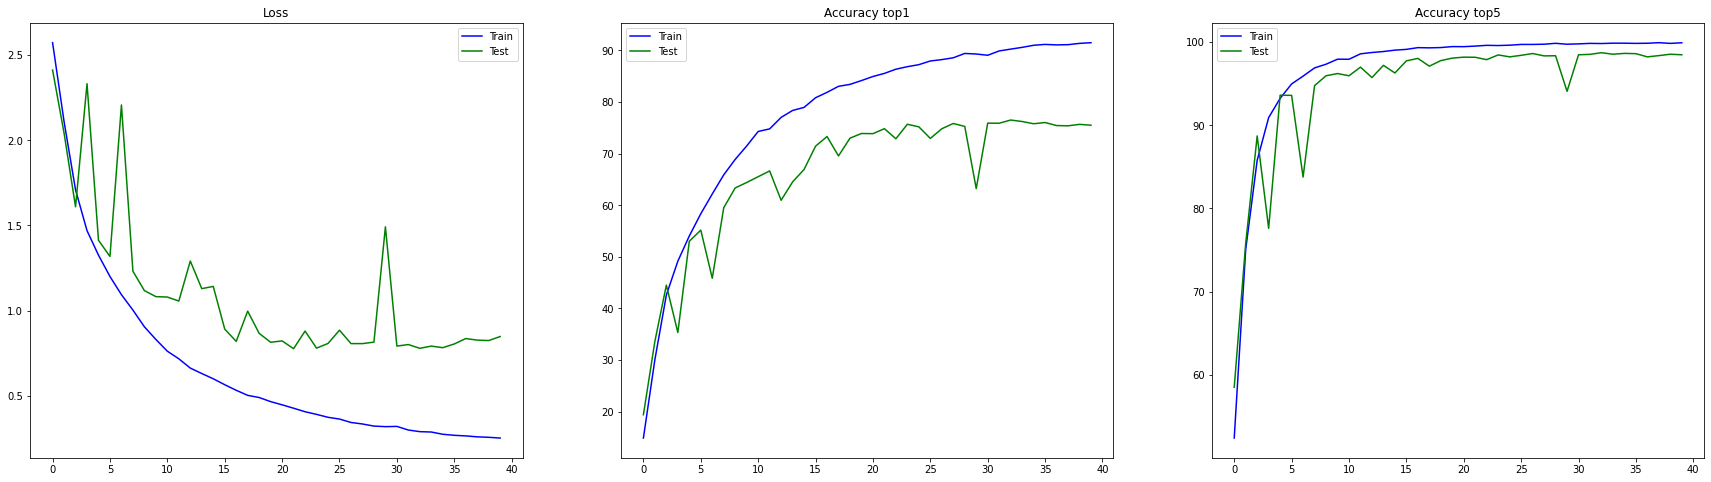

In [ ]:
plot_learned(all_train_loss,all_train_acc,all_test_loss,all_test_acc,train_top5_list, test_top5_list)